In [1]:
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import newaxis
import time
import holidays
import pickle
import warnings
warnings.filterwarnings("ignore") # may not always be the best thing to do...
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

## Link colab to your google drive
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Nilm metric
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

# Custom metric for fit
def custom_metric(y_true, y_pred):
        score = mt.sqrt(sum((y_pred.get_label() - y_true) ** 2) / len(y_true)) * 5.55
        score /= 74.86
        return "nilm", score

# Create final y dataframe
def create_y_predictions(x_out_old, x_out, best_model):
  Y_out_temp = best_model.predict(x_out)
  df = pd.DataFrame(Y_out_temp)
  Y_out = pd.DataFrame(x_out_old["time_step"])
  Y_out["washing_machine"] = df.iloc[:,0]
  Y_out["fridge_freezer"] = df.iloc[:,1]
  Y_out["TV"] = df.iloc[:,2]
  Y_out["kettle"] = df.iloc[:,3]
  Y_out.index = Y_out.time_step #ligne de nao
  Y_out.to_csv('y_out.csv', header=True,index=False)
  print(Y_out)
  files.download("y_out.csv")
  return Y_out

#Modif of output
def modif_output(y_pred2_df):
  y_pred2_df['kettle'] = y_pred2_df['kettle'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['TV'] = y_pred2_df['TV'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['fridge_freezer'] = y_pred2_df['fridge_freezer'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['washing_machine'] = y_pred2_df['washing_machine'].apply(lambda x : 0 if x<=1 else x)
  return y_pred2_df

In [3]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data.csv")
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute,n_days,is_holiday,is_weekend,sin_hour,cos_hour,sin_day,cos_day,sin_dow,cos_dow,peak_hours,is_breakfast,is_teatime,is_evening,avg_hourly_consumption,avg_day_of_weekly_consumption,avg_hourly_washing_machine,avg_day_of_weekly_washing_machine,avg_hourly_fridge_freezer,avg_day_of_weekly_fridge_freezer,avg_hourly_TV,avg_day_of_weekly_TV,avg_hourly_kettle,...,log_conso + 1,log_conso - 2,log_conso + 2,log_conso - 3,log_conso + 3,log_conso - 5,log_conso + 5,log_conso - 10,log_conso + 10,log_conso - 30,log_conso + 30,log_conso - 60,log_conso + 60,log_conso - 120,log_conso + 120,conso_normalised,conso / mvg_std_10,conso / mvg_std_30,conso / mvg_std_60,conso_trend,conso_anomaly,conso_low,conso_cumsum_mvg_avg_30,moving_conso_mean_3,conso - mvg_avg_3,moving_conso_mean_5,conso - mvg_avg_5,conso_cumsum_mvg_avg_3,conso_cumsum_mvg_avg_5,conso_cumsum_mvg_avg_10,conso_cumsum_mvg_avg_15,conso_cumsum_mvg_avg_20,conso_cumsum_mvg_avg_60,cumsum_diff_3,cumsum_diff_5,cumsum_diff_10,cumsum_diff_15,cumsum_diff_20,cumsum_diff_30,cumsum_diff_60
0,550.4000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,6,1,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307370,6.310645,6.308645,6.310645,6.308766,6.310645,6.309251,6.310645,6.305180,6.310645,6.369730,6.310645,6.424058,6.310645,6.288849,473.890573,802.337957,69.811813,22.620646,520.917237,0,0,4.382633,549.433333,0.966667,549.31152,1.08848,0.966667,1.088480e+00,1.12024,3.326827,5.96637,-14.83883,0.000000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000
1,548.6000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,6,2,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308645,6.310645,6.308766,6.310645,6.307900,6.310645,6.307135,6.310645,6.303534,6.310645,6.356108,6.310645,6.293543,6.310645,6.289509,472.090573,802.337957,69.811813,22.620646,520.827729,0,0,6.965267,549.433333,-0.833333,549.31152,-0.71152,0.133333,3.769600e-01,0.44048,4.853653,10.13274,-31.47766,-0.700000,-0.70000,-0.7000,-0.7000,-0.7000,-0.7000,-0.7000
2,549.3000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,6,3,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308766,6.310645,6.307900,6.310645,6.309251,6.310645,6.310311,6.310645,6.303900,6.310645,6.352629,6.310645,6.293789,6.310645,6.276435,472.790573,802.337957,69.811813,22.620646,520.738222,0,0,10.247900,549.433333,-0.133333,549.31152,-0.01152,0.000000,3.654400e-01,0.46072,7.080480,14.99911,-47.41649,-0.411133,-0.06670,-0.0667,-0.0667,-0.0667,-0.0667,-0.0667
3,549.3667,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,6,4,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307900,6.307370,6.309251,6.310645,6.307135,6.310645,6.308908,6.310645,6.289344,6.310645,6.351584,6.310645,6.292495,6.310645,6.422882,472.857273,802.337957,69.811813,22.620646,520.648714,0,0,13.597233,549.088900,0.277800,549.31152,0.05518,0.277800,4.206200e-01,0.54766,9.374007,19.93218,-63.28862,0.572767,0.47580,0.4758,0.4758,0.4758,0.4758,0.4758
4,548.8909,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,6,5,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,

# Model 0 : 36.3 platform, 38.4 local

## 1. First fit an XGBoost on all four appliances. 

Added conso anomaly because it helps a lot on washing machine!

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10",
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60",]

In [0]:
temp_features = ["rolling_std_future_5", "rolling_std_future_10", "rolling_std_past_5", "rolling_std_past_10",
                 "rolling_std_future_3", "rolling_std_past_3","rolling_max_5", "rolling_max_3",]

In [0]:
selected_features =  ['consumption', 
                      'conso - 1', 'conso - 2', 'conso - 3', 'conso - 5', 'conso - 10', 'conso - 30', 'conso - 60',
                      'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                      'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                      'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                      'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                      'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                      'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
                      'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
                      "conso - mvg_avg_10","conso - mvg_avg_30","conso - mvg_avg_60",
                      "conso - mvg_avg_15", "conso - mvg_avg_20",
                      "conso - avg_hourly_kettle",
                      'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'cos_dow', 'sin_dow',
                      'n_days', "hour", "month", "day_of_week",
                      'temperature','pressure',
                      'peak_hours', 
                      'avg_hourly_consumption', 'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                      'avg_day_of_weekly_consumption','avg_day_of_weekly_washing_machine','avg_day_of_weekly_fridge_freezer',
                      'avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                     # "conso_anomaly",
                      "rolling_std_future_5", "rolling_std_future_10", "rolling_std_past_5", "rolling_std_past_10",
                      "rolling_std_future_3", "rolling_std_past_3","rolling_max_5", "rolling_max_3",
                      ]

In [0]:
X = data.loc[:,selected_features]
y = data.loc[:, "washing_machine":"kettle"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [68]:
xgb_reg = XGBRegressor(n_estimators=300,
                       learning_rate = 0.1,
                       max_depth=3)
multi_reg = MultiOutputRegressor(xgb_reg,n_jobs=-1)
multi_reg.fit(X_train,y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=300,
                                            n_jobs=1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbos

In [0]:
#Prepare y_pred to be able to use their custom metrics
y_pred = multi_reg.predict(X_test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_df.index = y_test.index

#Prepare y_pred_train to be able to use their custom metrics
y_pred_train = multi_reg.predict(X_train)
y_pred_train_df = pd.DataFrame(y_pred_train)
y_pred_train_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_train_df.index = y_train.index

In [70]:
metric_nilm(y_test, y_pred_df), metric_nilm(y_train, y_pred_train_df) 

(38.02970613789796, 29.858710968120402)

In [71]:
# Fridge freezer
pred = y_pred[:,1]
test = y_test.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

26.49439360179245

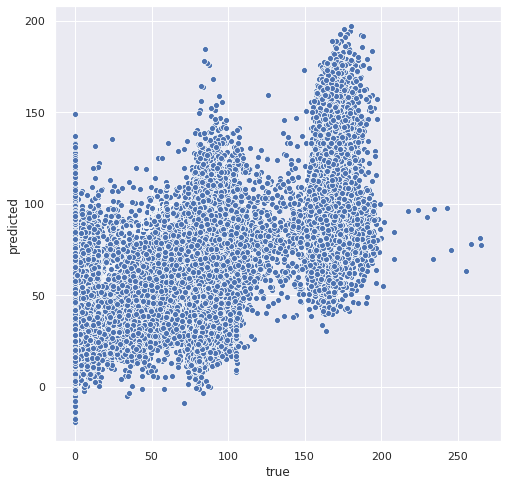

In [72]:
df = pd.DataFrame(y_pred_df["fridge_freezer"])
df["true"] = y_test["fridge_freezer"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [73]:
# Fridge freezer on train
pred = y_pred_train[:,1]
test = y_train.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

23.593381883042902

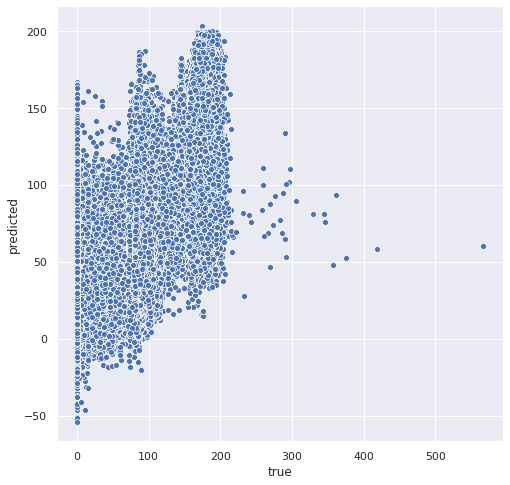

In [74]:
df1 = pd.DataFrame(y_pred_train_df["fridge_freezer"])
df1["true"] = y_train["fridge_freezer"]
df1.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df1)

In [75]:
# TV
pred = y_pred[:,2]
test = y_test.iloc[:,2]
mt.sqrt(sum((pred - test)**2)/len(test))*14.57/74.86

2.964666992669283

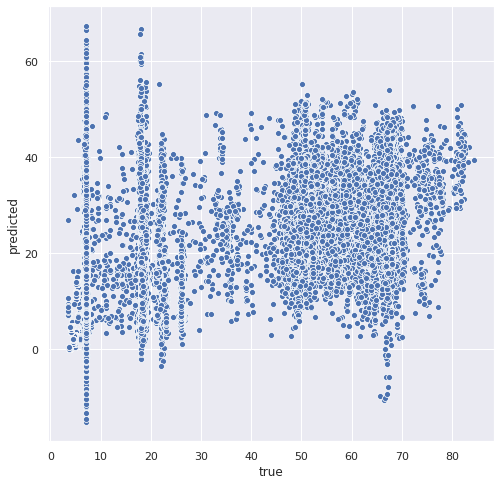

In [76]:
df = pd.DataFrame(y_pred_df["TV"])
df["true"] = y_test["TV"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [77]:
# TV train
pred = y_pred_train[:,2]
test = y_train.iloc[:,2]
mt.sqrt(sum((pred - test)**2)/len(test))*14.57/74.86

2.276436301962061

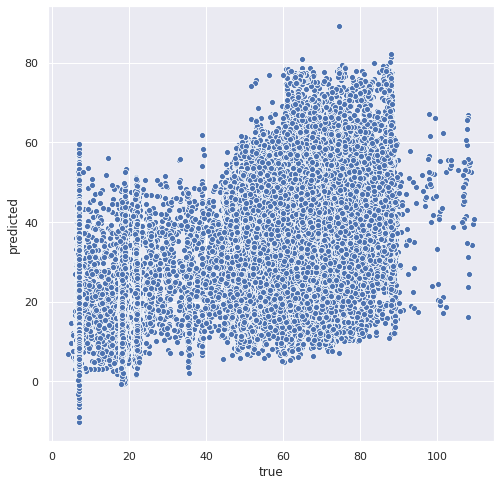

In [78]:
df1 = pd.DataFrame(y_pred_train_df["TV"])
df1["true"] = y_train["TV"]
df1.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df1)

In [79]:
# Kettle
pred = y_pred[:,3]
test = y_test.iloc[:,3]
mt.sqrt(sum((pred - test)**2)/len(test))*4.95/74.86

5.353584730660971

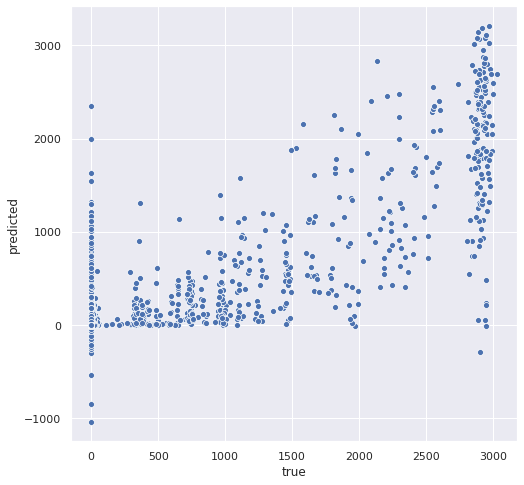

In [59]:
df = pd.DataFrame(y_pred_df["kettle"])
df["true"] = y_test["kettle"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [60]:
# Kettle train
pred = y_pred_train[:,3]
test = y_train.iloc[:,3]
mt.sqrt(sum((pred - test)**2)/len(test))*4.95/74.86

2.0715825696814987

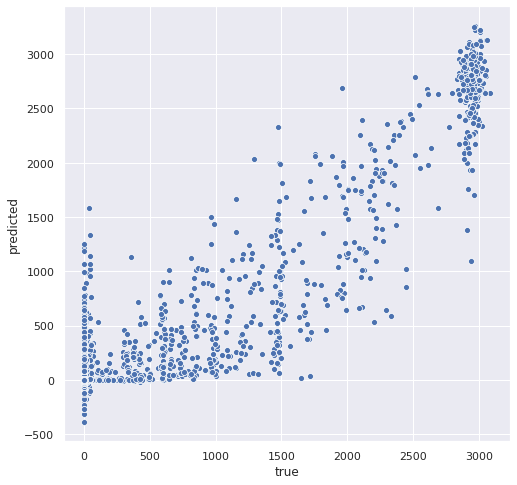

In [61]:
df1 = pd.DataFrame(y_pred_train_df["kettle"])
df1["true"] = y_train["kettle"]
df1.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df1)

In [62]:
# Washing machine
pred = y_pred[:,0]
test = y_test.iloc[:,0]
mt.sqrt(sum((pred - test)**2)/len(test))*5.55/74.86

3.262553523469556

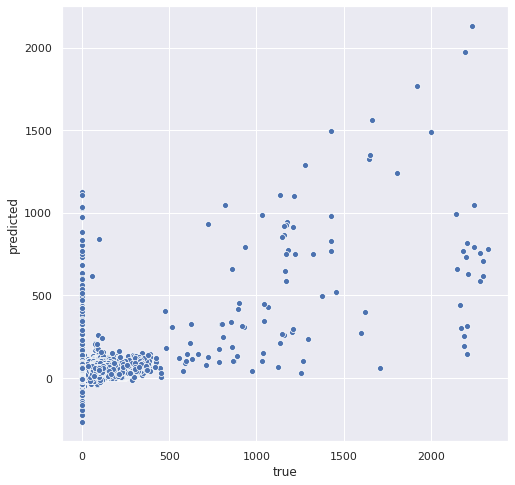

In [63]:
df = pd.DataFrame(y_pred_df["washing_machine"])
df["true"] = y_test["washing_machine"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [64]:
# Washing machine train
pred = y_pred_train[:,0]
test = y_train.iloc[:,0]
mt.sqrt(sum((pred - test)**2)/len(test))*5.55/74.86

2.054641587947317

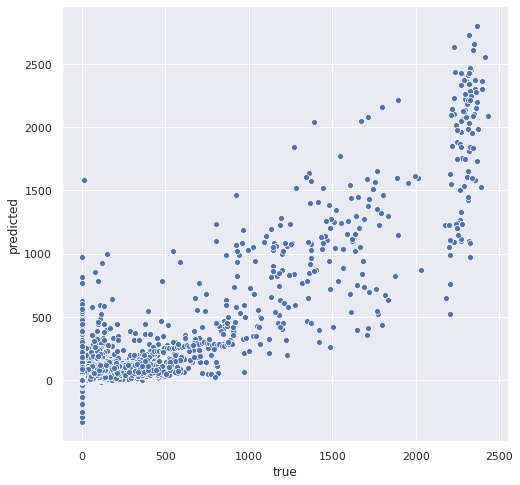

In [65]:
df1 = pd.DataFrame(y_pred_train_df["washing_machine"])
df1["true"] = y_train["washing_machine"]
df1.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df1)

In [0]:
x_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/x_out.csv")

In [28]:
x_out = x_out[selected_features]
x_out.head()

,consumption,conso - 1,conso - 2,conso - 3,conso - 5,conso - 10,conso - 30,conso - 60,conso + 1,conso + 2,conso + 3,conso + 5,conso + 10,conso + 30,conso + 60,moving_conso_mean_10,moving_conso_mean_30,moving_conso_mean_60,moving_conso_max_10,moving_conso_max_30,moving_conso_max_60,moving_conso_min_10,moving_conso_min_30,moving_conso_min_60,moving_conso_std_10,moving_conso_std_30,moving_conso_std_60,moving_conso_mean_15,moving_conso_min_15,moving_conso_max_15,moving_conso_mean_20,moving_conso_min_20,moving_conso_max_20,conso - mvg_avg_10,conso - mvg_avg_30,conso - mvg_avg_60,conso - mvg_avg_15,conso - mvg_avg_20,conso - avg_hourly_kettle,cos_hour,sin_hour,cos_day,sin_day,cos_dow,sin_dow,n_days,hour,month,day_of_week,temperature,pressure,peak_hours,avg_hourly_consumption,avg_hourly_washing_machine,avg_hourly_fridge_freezer,avg_hourly_TV,avg_hourly_kettle,avg_day_of_weekly_consumption,avg_day_of_weekly_washing_machine,avg_day_of_weekly_fridge_freezer,avg_day_of_weekly_TV,avg_day_of_weekly_kettle,conso_anomaly
0,312.2222,310.4444,312.0000,310.5000,342.6667,1632.7500,2288.7778,408.8889,318.8750,314.3000,311.4444,304.7778,258.5556,239.1111,237.7778,306,263,267,318,318,330,270,237,237,12,32,34,286,240,318,275,240,318,6.2222,49.2222,45.2222,26.2222,37.2222,312.219626,1.0,0.0,0.97953,0.201299,-0.222521,0.974928,16071,0,1,2,8.4,1016.6,0,275.842073,16.666658,50.053807,9.791535,0.002574,294.324385,4.811761,49.394849,14.731168,5.213072,0
1,318.8750,312.2222,310.4444,312.0000,311.5556,454.5556,2270.3750,313.5556,314.3000,311.4444,310.0000,305.2222,241.2500,278.8889,238.1111,306,263,267,318,318,330,270,237,237,12,32,34,286,240,318,275,240,318,12.8750,55.8750,51.8750,32.8750,43.8750,318.872426,1.0,0.0,0.97953,0.201299,-0.222521,0.974928,16071,0,1,2,8.4,1016.6,0,275.842073,16.666658,50.053807,9.791535,0.002574,294.324385,4.811761,49.394849,14.731168,5.213072,0
2,314.3000,318.8750,312.2222,310.4444,310.5000,438.3000,2245.7778,314.6250,311.4444,310.0000,304.7778,304.2222,240.5556,329.7500,236.2500,306,263,267,318,318,330,270,237,237,12,32,34,286,240,318,275,240,318,8.3000,51.3000,47.3000,28.3000,39.3000,314.297426,1.0,0.0,0.97953,0.201299,-0.222521,0.974928,16071,0,1,2,8.4,1016.6,0,275.842073,16.666658,50.053807,9.791535,0.002574,294.324385,4.811761,49.394849,14.731168,5.213072,0
3,311.4444,314.3000,318.8750,312.2222,312.0000,418.4444,2269.8889,309.1111,310.0000,304.7778,305.2222,316.5556,243.3333,324.3333,235.6667,306,263,267,318,318,330,270,237,237,12,32,34,286,240,318,275,240,318,5.4444,48.4444,44.4444,25.4444,36.4444,311.441826,1.0,0.0,0.97953,0.201299,-0.222521,0.974928,16071,0,1,2,8.4,1016.6,0,275.842073,16.666658,50.053807,9.791535,0.002574,294.324385,4.811761,49.394849,14.731168,5.213072,0
4,310.0000,311.4444,314.3000,318.8750,310.4444,407.8750,2304.7500,318.7778,304.7778,305.2222,304.2222,270.8889,243.6250,268.6667,241.0000,306,263,267,318,318,330,270,237,237,12,32,34,286,240,318,275,240,318,4.0000,47.0000,43.0000,24.0000,35.0000,309.997426,1.0,0.0,0.97953,0.201299,-0.222521,0.974928,16071,0,1,2,8.4,1016.6,0,275.842073,16.666658,50.053807,9.791535,0.002574,294.324385,4.811761,49.394849,14.731168,5.213072,0


In [0]:
#xgb_reg = XGBRegressor(n_estimators=300,
#                       learning_rate = 0.1,
#                       max_depth=3)
#multi_reg = MultiOutputRegressor(xgb_reg,n_jobs=-1)
#multi_reg.fit(X,y)

In [0]:
Y_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_TV_4.csv")

In [0]:
x_out = x_out.fillna(method="ffill").fillna(method="bfill")

In [0]:
Y_out["washing_machine"] = multi_reg.predict(x_out)[:,0]

In [0]:
#Y_out.to_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_wm_3_full_data.csv", index=False)

## 2. Then predict washing machine on its own

In [34]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data.csv")
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute,n_days,is_holiday,is_weekend,sin_hour,cos_hour,sin_day,cos_day,sin_dow,cos_dow,peak_hours,is_breakfast,is_teatime,is_evening,avg_hourly_consumption,avg_day_of_weekly_consumption,avg_hourly_washing_machine,avg_day_of_weekly_washing_machine,avg_hourly_fridge_freezer,avg_day_of_weekly_fridge_freezer,avg_hourly_TV,avg_day_of_weekly_TV,avg_hourly_kettle,...,log_conso + 1,log_conso - 2,log_conso + 2,log_conso - 3,log_conso + 3,log_conso - 5,log_conso + 5,log_conso - 10,log_conso + 10,log_conso - 30,log_conso + 30,log_conso - 60,log_conso + 60,log_conso - 120,log_conso + 120,conso_normalised,conso / mvg_std_10,conso / mvg_std_30,conso / mvg_std_60,conso_trend,conso_anomaly,conso_low,conso_cumsum_mvg_avg_30,moving_conso_mean_3,conso - mvg_avg_3,moving_conso_mean_5,conso - mvg_avg_5,conso_cumsum_mvg_avg_3,conso_cumsum_mvg_avg_5,conso_cumsum_mvg_avg_10,conso_cumsum_mvg_avg_15,conso_cumsum_mvg_avg_20,conso_cumsum_mvg_avg_60,cumsum_diff_3,cumsum_diff_5,cumsum_diff_10,cumsum_diff_15,cumsum_diff_20,cumsum_diff_30,cumsum_diff_60
0,550.4000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,6,1,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307370,6.310645,6.308645,6.310645,6.308766,6.310645,6.309251,6.310645,6.305180,6.310645,6.369730,6.310645,6.424058,6.310645,6.288849,473.890573,802.337957,69.811813,22.620646,520.917237,0,0,4.382633,549.433333,0.966667,549.31152,1.08848,0.966667,1.088480e+00,1.12024,3.326827,5.96637,-14.83883,0.000000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000
1,548.6000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,6,2,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308645,6.310645,6.308766,6.310645,6.307900,6.310645,6.307135,6.310645,6.303534,6.310645,6.356108,6.310645,6.293543,6.310645,6.289509,472.090573,802.337957,69.811813,22.620646,520.827729,0,0,6.965267,549.433333,-0.833333,549.31152,-0.71152,0.133333,3.769600e-01,0.44048,4.853653,10.13274,-31.47766,-0.700000,-0.70000,-0.7000,-0.7000,-0.7000,-0.7000,-0.7000
2,549.3000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,6,3,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308766,6.310645,6.307900,6.310645,6.309251,6.310645,6.310311,6.310645,6.303900,6.310645,6.352629,6.310645,6.293789,6.310645,6.276435,472.790573,802.337957,69.811813,22.620646,520.738222,0,0,10.247900,549.433333,-0.133333,549.31152,-0.01152,0.000000,3.654400e-01,0.46072,7.080480,14.99911,-47.41649,-0.411133,-0.06670,-0.0667,-0.0667,-0.0667,-0.0667,-0.0667
3,549.3667,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,6,4,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307900,6.307370,6.309251,6.310645,6.307135,6.310645,6.308908,6.310645,6.289344,6.310645,6.351584,6.310645,6.292495,6.310645,6.422882,472.857273,802.337957,69.811813,22.620646,520.648714,0,0,13.597233,549.088900,0.277800,549.31152,0.05518,0.277800,4.206200e-01,0.54766,9.374007,19.93218,-63.28862,0.572767,0.47580,0.4758,0.4758,0.4758,0.4758,0.4758
4,548.8909,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,6,5,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10", 
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60",

                    'avg_day_of_weekly_washing_machine','avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                    'avg_day_of_weekly_consumption','avg_day_of_weekly_fridge_freezer',

                    "minutely_std_fridge_freezer", # all removed from fridge freezer

                    "rolling_std_future_5", "rolling_std_future_10", "rolling_std_past_5", "rolling_std_past_10",
                    "rolling_std_future_3", "rolling_std_past_3",
                    ]

In [0]:
features_kettle = ['consumption', 
                   'conso - 1', 'conso - 2', 'conso - 3', 'conso - 5', 'conso - 10', 'conso - 30', 'conso - 60',
                   'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                   'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                   'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                   'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                   'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                   'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
                   'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
                   "conso - mvg_avg_10","conso - mvg_avg_30","conso - mvg_avg_60",
                   "conso - mvg_avg_15", "conso - mvg_avg_20",
                   "conso - avg_hourly_kettle",
                   'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'cos_dow', 'sin_dow',
                   'n_days', "hour", "month", "day_of_week",
                   'temperature','pressure',
                   'peak_hours', 
                   'avg_hourly_consumption', 'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                   'avg_day_of_weekly_consumption','avg_day_of_weekly_washing_machine','avg_day_of_weekly_fridge_freezer',
                   'avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                   "conso_anomaly"
                      ]

In [0]:
X2 = data.loc[:, selected_features]
y2 = data.loc[:, "washing_machine":"kettle"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                        y2, 
                                                        test_size=0.20, 
                                                        shuffle=False)

In [38]:
xgb_reg = XGBRegressor(n_estimators=300,
                       max_depth = 3,
                       learning_rate=0.1)
xgb_reg.fit(X_train2,
            y_train2.iloc[:,0],
            eval_set=[(X_test2, y_test2.iloc[:,0])],
            eval_metric=custom_metric,)
            #early_stopping_rounds=10)

[19:39:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:55.3793	validation_0-nilm:4.10573
[1]	validation_0-rmse:54.0646	validation_0-nilm:4.00826
[2]	validation_0-rmse:53.0161	validation_0-nilm:3.93053
[3]	validation_0-rmse:52.4479	validation_0-nilm:3.8884
[4]	validation_0-rmse:51.6888	validation_0-nilm:3.83212
[5]	validation_0-rmse:51.0628	validation_0-nilm:3.78571
[6]	validation_0-rmse:50.6347	validation_0-nilm:3.75398
[7]	validation_0-rmse:50.1155	validation_0-nilm:3.71548
[8]	validation_0-rmse:49.53	validation_0-nilm:3.67208
[9]	validation_0-rmse:49.2333	validation_0-nilm:3.65008
[10]	validation_0-rmse:49.0186	validation_0-nilm:3.63416
[11]	validation_0-rmse:48.6998	validation_0-nilm:3.61053
[12]	validation_0-rmse:48.6002	validation_0-nilm:3.60314
[13]	validation_0-rmse:48.0796	validation_0-nilm:3.56455
[14]	validation_0-rmse:48.039	validation_0-nilm:3.56153
[15]	validation_0-rmse:47.8917	v

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

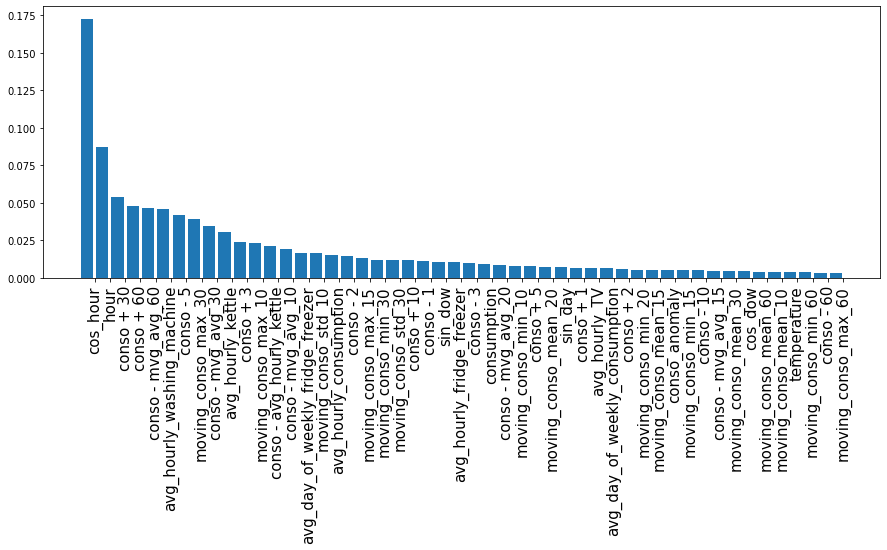

In [39]:
# Looking at the importance of each column and the prediction 
X_columns = X_train2.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(xgb_reg.feature_importances_)[::-1][:50]
importances = xgb_reg.feature_importances_[ordering]
feature_names = X_columns[ordering]
axis = np.arange(len(feature_names))
plt.bar(axis, importances)
plt.xticks(axis + 0.5, feature_names, rotation=90, fontsize=15);

In [40]:
# Metric nilm washing machine
pred = xgb_reg.predict(X_test2)
test = y_test2.iloc[:,0]
mt.sqrt(sum((pred - test)**2)/len(test))*5.55/74.86

3.2896060659989153

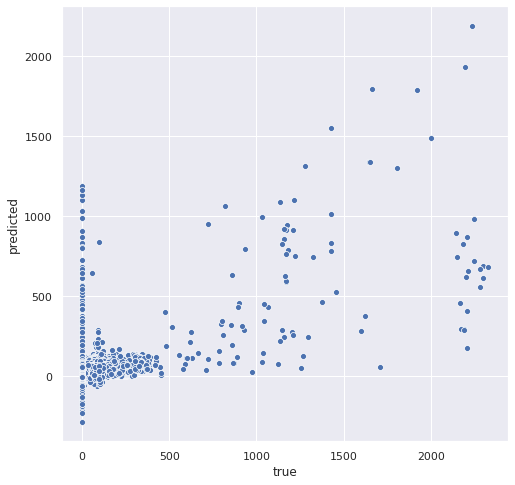

In [41]:
df = pd.DataFrame(pred)
df["true"] = np.array(test)
df.columns = ["predicted","true"]
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x= "true",y = "predicted", data=df)

In [0]:
#xgb_reg = XGBRegressor(n_estimators=100,
#                       max_depth = 10,
#                       learning_rate=0.1)
#xgb_reg.fit(X2,
#            y2.iloc[:,2],
#            early_stopping_rounds=3)

In [0]:
x_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/x_out.csv")
Y_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_wm_3_full_data.csv")

In [0]:
#Y_out.to_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_TV_4.csv", index=False)